# Segmenting and Clustering Neighborhoods in Toronto
Applied Data Science Capstone (Coursera. )Peer-graded Assignment. 
For this assignment, we will be required to explore and cluster the neighborhoods in Toronto

For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. We will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format. 

## Part 1
Explore the data


### 1.1 Importing necessary libraries

In [47]:
import pandas as pd # library to handle data in a vectorized manner
import numpy as np # library for data analsysis
from bs4 import BeautifulSoup as bs # library for web scraping
import requests # Library for web scraping

!pip install lxml

print('Libraries imported!')

Libraries imported!


### 1.2 Importing Data

Using BeautifulSopu library to get the html data from wikipedia page

In [48]:
source=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup=bs(source,'lxml')
article=soup.find('tbody')


Filtering the html data so we can get only the table with Toronto Neighborhoods values, and place them into a dataframe

In [49]:
to_table=article.find_all('tr') 

table=[]
for row in to_table:
    table.append([t.text.strip() for t in row.find_all('td')]) #take every row values from wikipedia table

df = pd.DataFrame(table, columns=['Postal Code', 'Borough', 'Neighborhood']) #Create Dataframe with selected columns from table
df = df[~df['Postal Code'].isnull()] # To discard rows with null values
df.shape

(287, 3)

Let's see the dataframe

In [50]:
df.head()

,Postal Code,Borough,Neighborhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


### 1.3 Cleaning Dataset

In [51]:
#To ignore cells with a borough that is 'Not assigned':
df.drop(df[df['Borough']=="Not assigned"].index,axis=0, inplace=True)

#To combined into one row all the neighborhoods with same postal code area, separated with a comma:
df1= df.groupby('Postal Code').agg(lambda x: ','.join(x)) 

#If a cell has a borough but a 'Not assigned' neighborhood, then the neighborhood will be the same as the borough:
df1.loc[df1['Neighborhood']=="Not assigned",'Neighborhood'] = df1.loc[df1['Neighborhood']=="Not assigned",'Borough'] 
df1 = df1.reset_index()

df1['Borough']= df1['Borough'].str.replace('nan|[{}\s]','').str.split(',').apply(set).str.join(',').str.strip(',').str.replace(",{2,}",",") 

df1.shape

(103, 3)

### Let's see the result dataframe of part 1

In [52]:
df1.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


## Part 2
Now that we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

### 2.1 Importing file with coordinates of each postal code

In [53]:
path='https://cocl.us/Geospatial_data'
pc_coord = pd.read_csv(path)


pc_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### 2.3 Merging Data

To obtain Latitude and Longitude of each Postal Code

In [54]:
df2=pd.merge(df1, pc_coord, on='Postal Code', how='right') # To merge the data
df2.shape

(103, 5)

### Let's see the result data of part 2:

In [55]:
df2.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Part 3

Clustering neighborhoods


### 3.1 Required Libraries

In [56]:
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


### 3.2 Defining Foursquare Credentials and Version 

In [57]:
CLIENT_ID = 'USDIHUTTFPQNVC1DB410W3T25VTUDQEFMSE2YPEISSOQAKBK' # your Foursquare ID
CLIENT_SECRET = 'OS3US4HDDQBN0ZA03I4YSED53YMUROHWW32GSEAFPHHH4C1X' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: USDIHUTTFPQNVC1DB410W3T25VTUDQEFMSE2YPEISSOQAKBK
CLIENT_SECRET:OS3US4HDDQBN0ZA03I4YSED53YMUROHWW32GSEAFPHHH4C1X


First, we define the coordinates of the neighborhood 

In [58]:
neighborhood_latitude = df2.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df2.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df2.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Rouge,Malvern are 43.806686299999996, -79.19435340000001.



Using Foursquare, we will define a function to get all values from a selected location, Toronto in this case

In [59]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's use the above function to get Toronto venues

In [60]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
toronto_venues = getNearbyVenues(names=df2['Neighborhood'],
                                   latitudes=df2['Latitude'],
                                   longitudes=df2['Longitude']
                                  )

Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beaches West,Indi

Let's see our results

In [61]:
print(toronto_venues.shape)
toronto_venues.head()

(2246, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


and, 
how many places have been found?

In [62]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 269 uniques categories.


### 3.3 Analyzing Each Neighborhood

In [63]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category:

In [64]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide,King,Richmond",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,...,0.0,0.020000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.01
1,Agincourt,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.090909,0.000000,0.000000,0.000000,0.000000,0.0,0.00
4,"Alderwood,Long Branch",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00
5,"Bathurst Manor,Downsview North,Wilson Heights",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.050000,0.000000,0.000000,0.000000,0.000000,0.0,0.00
6,Bayview Village,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00
7,"Bedford Park,Lawrence Manor East",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,...,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00
8,Berczy Park,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.017241,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00
9,"Birch Cliff,Cliffside West",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00


Let's print each neighborhood along with the top 5 most common venues and place that into a pandas dataframe

In [65]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### 3.4 placing data into a pandas dataframe:

In [66]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Steakhouse,Bar,Breakfast Spot,Thai Restaurant,Hotel,Restaurant,Asian Restaurant,Seafood Restaurant
1,Agincourt,Clothing Store,Latin American Restaurant,Lounge,Breakfast Spot,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Park,Playground,Coffee Shop,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Fast Food Restaurant,Japanese Restaurant,Fried Chicken Joint,Discount Store,Sandwich Place,Beer Store,Video Store,Pizza Place,Pharmacy
4,"Alderwood,Long Branch",Pizza Place,Coffee Shop,Athletics & Sports,Pharmacy,Pool,Pub,Sandwich Place,Skating Rink,Gym,American Restaurant


## 4. Clustering Neighborhoods

### 4.1 Using k-mean clustering 
to classify neighborhoods into 5 class or clusters

In [67]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

### 4.2 let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood:

In [68]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [76]:
toronto_merged = df2

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged['Cluster Labels']= toronto_merged['Cluster Labels'].fillna(0)
toronto_merged['Cluster Labels']=toronto_merged['Cluster Labels'].astype(int)

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0,Fast Food Restaurant,Dim Sum Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,2,Bar,Women's Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Field
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0,Intersection,Mexican Restaurant,Pizza Place,Breakfast Spot,Electronics Store,Rental Car Location,Medical Center,Women's Store,Dog Run,Doner Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Korean Restaurant,Insurance Office,Women's Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Hakka Restaurant,Gas Station,Fried Chicken Joint,Bank,Bakery,Thai Restaurant,Athletics & Sports,Caribbean Restaurant,Cuban Restaurant,Discount Store


### 4.3 Visualizing resulting Clusters on Map
working with geopy

In [70]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


Creating Map

In [78]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

### Cluster Map Generated 
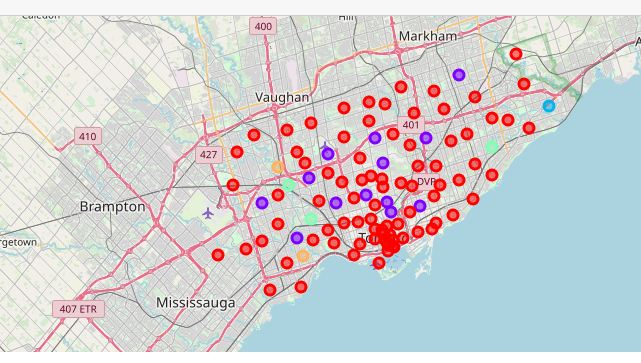

## 5. Exploring Clusters

#### Cluster 0

In [79]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,0,Fast Food Restaurant,Dim Sum Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
2,Scarborough,0,Intersection,Mexican Restaurant,Pizza Place,Breakfast Spot,Electronics Store,Rental Car Location,Medical Center,Women's Store,Dog Run,Doner Restaurant
3,Scarborough,0,Coffee Shop,Korean Restaurant,Insurance Office,Women's Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
4,Scarborough,0,Hakka Restaurant,Gas Station,Fried Chicken Joint,Bank,Bakery,Thai Restaurant,Athletics & Sports,Caribbean Restaurant,Cuban Restaurant,Discount Store
6,Scarborough,0,Discount Store,Department Store,Chinese Restaurant,Coffee Shop,Hobby Shop,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
7,Scarborough,0,Bakery,Bus Line,Soccer Field,Intersection,Park,Metro Station,Bus Station,Ice Cream Shop,Dog Run,Doner Restaurant
8,Scarborough,0,Motel,American Restaurant,Movie Theater,Dim Sum Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Women's Store
9,Scarborough,0,College Stadium,General Entertainment,Skating Rink,Café,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
10,Scarborough,0,Indian Restaurant,Pet Store,Vietnamese Restaurant,Thrift / Vintage Store,Chinese Restaurant,Furniture / Home Store,Construction & Landscaping,Convenience Store,Event Space,Ethiopian Restaurant
11,Scarborough,0,Middle Eastern Restaurant,Bakery,Smoke Shop,Breakfast Spot,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Women's Store


#### Cluster 1

In [80]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,1,Park,Playground,Coffee Shop,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
23,NorthYork,1,Park,Bank,Bar,Convenience Store,Women's Store,Eastern European Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
25,NorthYork,1,Park,Pool,Food & Drink Shop,Women's Store,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
30,NorthYork,1,Park,Snack Place,Airport,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
40,EastYork,1,Park,Coffee Shop,Convenience Store,Women's Store,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
44,CentralToronto,1,Lawyer,Swim School,Bus Line,Park,Golf Course,Gluten-free Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store
48,CentralToronto,1,Trail,Park,Playground,Summer Camp,Women's Store,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
50,DowntownToronto,1,Park,Playground,Trail,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore
64,CentralToronto,1,Park,Bus Line,Jewelry Store,Sushi Restaurant,Trail,Women's Store,Drugstore,Dog Run,Doner Restaurant,Donut Shop
74,York,1,Park,Women's Store,Market,Fast Food Restaurant,Event Space,Ethiopian Restaurant,Falafel Restaurant,Empanada Restaurant,Diner,Eastern European Restaurant


#### Cluster 2

In [81]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,2,Bar,Women's Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Field


#### Cluster 3

In [82]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Scarborough,3,Playground,Convenience Store,Women's Store,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
81,York,3,Grocery Store,Pizza Place,Brewery,Convenience Store,Women's Store,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop
98,York,3,Convenience Store,Women's Store,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store


#### Cluster 4

In [83]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Etobicoke,4,Construction & Landscaping,Baseball Field,Women's Store,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
97,NorthYork,4,Baseball Field,Women's Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Field


### 6. Final Shape of Data 

In [84]:
toronto_merged.shape

(103, 16)